<a href="https://colab.research.google.com/github/liobaDB/DS/blob/main/Cryptocurrency%20price%20prediction%20using%20LSTMs_TensorFlow%20for%20Hackers%20(Part%20III).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-gpu==2.0.0-alpha0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0.0-alpha0 (from versions: 1.13.1, 1.13.2, 1.14.0, 1.15.0, 1.15.2, 1.15.3, 1.15.4, 1.15.5, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.4.4, 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0)
ERROR: No matching distribution found for tensorflow-gpu==2.0.0-alpha0


In [19]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

from keras.layers import Input, LSTM, Dense, TimeDistributed, Activation, BatchNormalization, Dropout, Bidirectional
from keras.models import Sequential
from keras.utils import Sequence
from keras.layers import CuDNNLSTM



%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [20]:
# Data comes from:
# https://finance.yahoo.com/quote/BTC-USD/history?period1=1279314000&period2=1556053200&interval=1d&filter=history&frequency=1d

csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/BTC-USD.csv"
# csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/AAPL.csv"

In [21]:
df = pd.read_csv(csv_path, parse_dates=['Date'])

In [22]:
df = df.sort_values('Date')

In [23]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-07-16,0.04951,0.04951,0.04951,0.04951,0.04951,0
1,2010-07-17,0.04951,0.08585,0.05941,0.08584,0.08584,5
2,2010-07-18,0.08584,0.09307,0.07723,0.08080,0.08080,49
3,2010-07-19,0.08080,0.08181,0.07426,0.07474,0.07474,20
4,2010-07-20,0.07474,0.07921,0.06634,0.07921,0.07921,42


In [24]:
df.shape

(3201, 7)

Text(0, 0.5, 'Close Price (USD)')

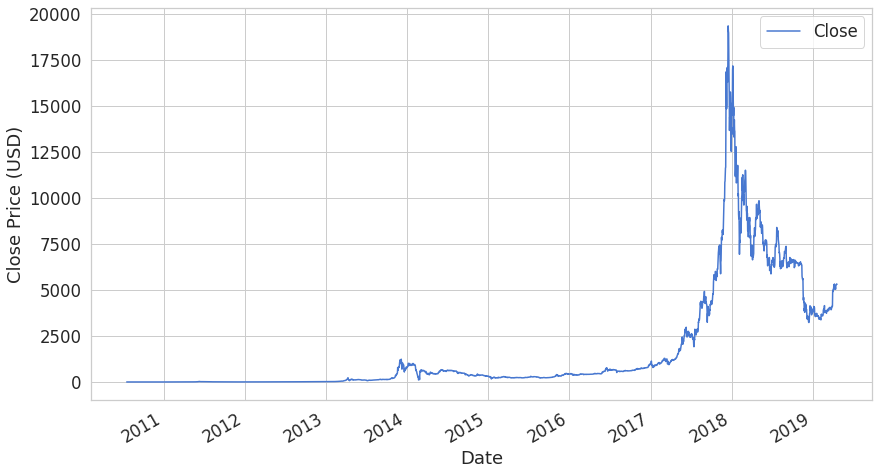

In [25]:
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

# Normalization

In [26]:
scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [27]:
scaled_close.shape

(3201, 1)

In [28]:
np.isnan(scaled_close).any()

False

In [29]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [30]:
scaled_close = scaled_close.reshape(-1, 1)

In [31]:
np.isnan(scaled_close).any()

False

# Preprocessing

In [32]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [33]:
X_train.shape

(2945, 99, 1)

In [34]:
X_test.shape

(156, 99, 1)

# Model

In [35]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

# Training

In [36]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [37]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50
42/42 [==============================] - 11s 67ms/step - loss: 0.0010 - val_loss: 0.0159
Epoch 2/50
42/42 [==============================] - 2s 41ms/step - loss: 0.0085 - val_loss: 0.0560
Epoch 3/50
42/42 [==============================] - 2s 41ms/step - loss: 0.0116 - val_loss: 0.0424
Epoch 4/50
42/42 [==============================] - 2s 41ms/step - loss: 0.0269 - val_loss: 0.1360
Epoch 5/50
42/42 [==============================] - 2s 41ms/step - loss: 0.0267 - val_loss: 0.0194
Epoch 6/50
42/42 [==============================] - 2s 42ms/step - loss: 0.0235 - val_loss: 0.0546
Epoch 7/50
42/42 [==============================] - 2s 41ms/step - loss: 0.0151 - val_loss: 0.0495
Epoch 8/50
42/42 [==============================] - 2s 41ms/step - loss: 0.0042 - val_loss: 0.0024
Epoch 9/50
42/42 [==============================] - 2s 41ms/step - loss: 0.0022 - val_loss: 0.0032
Epoch 10/50
42/42 [==============================] - 2s 41ms/step - loss: 0.0089 - val_loss: 0.0617
Epoch 11

In [38]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 47ms/step - loss: 0.0012


0.0011651327367872

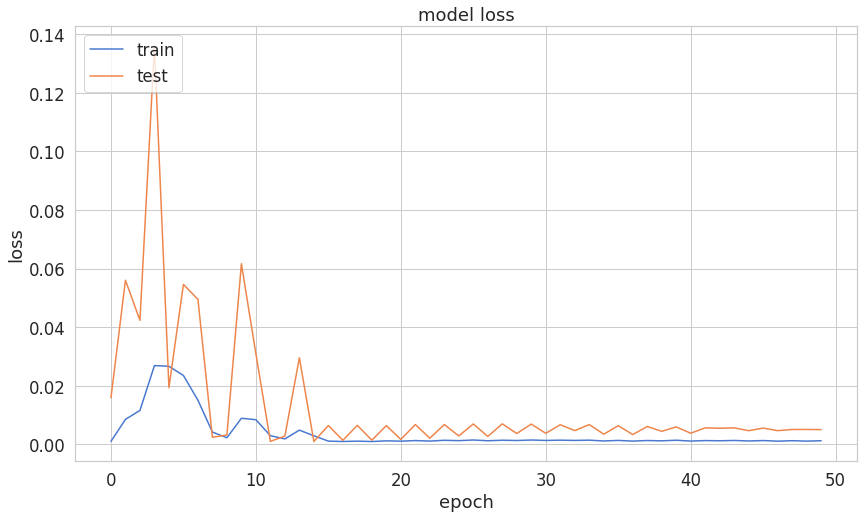

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

5/5 [==============================] - 1s 23ms/step


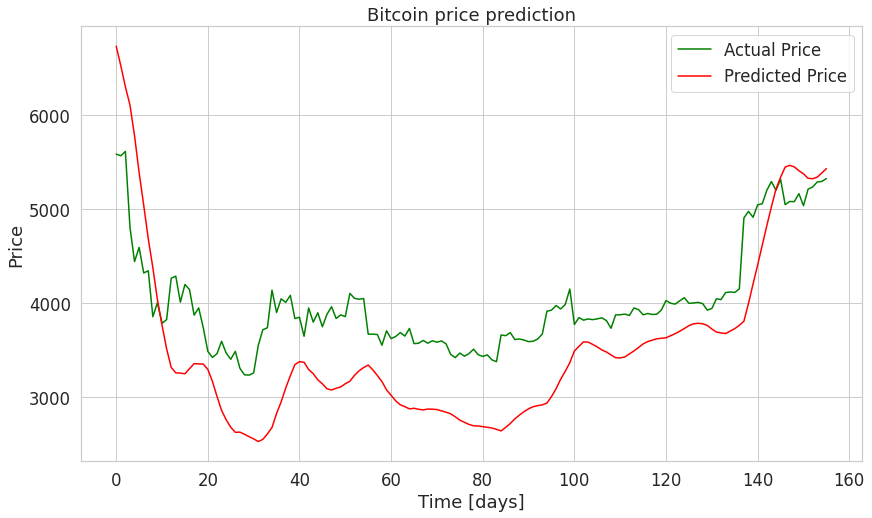

In [40]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();